In [1]:
import dougnet as dn
from dougnet.training import DataLoader, ProgressHelper
from dougnet.data import LoadCIFAR10
from dougnet.metrics import accuracy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import trange

In this notebook I will illustrate the benefits of using proper weight initialization, optimization algorithms and regularization by fitting an 8-layer MLP on the CIFAR-10 dataset.  I'll also be comparing the results of dougnet to pytorch for a sanity check.  I will procede in order of added benefit to model performance (which of course is subjective) from greatest to least and will therefore incorporate the following methods/functionality to the MLP model in turn:
- weight initialization
- optimizer algorithm
- batch norm
- dropout

In [2]:
# define some global vars

SEED_DATA = 1
SEED_WEIGHT = 4
SEED_DROPOUT = 9
BATCH_SIZE = 100
NUM_FEATURES_IN = [32 * 32 * 3, 100, 100, 100, 100, 100, 50, 50] # number of neurons in each layer
NUM_FEATURES_OUT = [100, 100, 100, 100, 100, 50, 50, 10] # number of neurons in each layer

# Load/Prep CIFAR-10 data

In [3]:
def PrepareData(X, y, n_classes, dtype=np.float32, seed=42):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size), y] = 1
    Y_ohe = Y_ohe.T
    
    # standardize
    X = ((X / 255.) - .5) * 2
    
    # get in N x C x H x W form
    X = X.transpose(0, 3, 1, 2)
    
    # flatten
    N, C, H, W = X.shape
    X = X.reshape(N, C * H * W).T

    ## randomly shuffle data
    random_perm = np.random.RandomState(seed=seed).permutation(X.shape[1])
    X = X[:, random_perm]
    Y_ohe = Y_ohe[:, random_perm]
    return X.astype(dtype), Y_ohe.astype(dtype)

# LOAD CIFAR10 DATA FOR TESTING AND DO BASIC DATA PREP
X_train, Y_train, X_val, Y_val = LoadCIFAR10()
X_train, Y_train = PrepareData(X_train, Y_train, 10)
X_val, Y_val = PrepareData(X_val, Y_val, 10)

# de-OHE ys
Y_train_deohe = np.argmax(Y_train, axis=0).astype(np.int64)
Y_val_deohe = np.argmax(Y_val, axis=0).astype(np.int64)

# turn data into tensors
X_train_tensor = torch.tensor(X_train.T)
Y_train_tensor = torch.tensor(Y_train_deohe.reshape(-1), dtype=torch.long)
X_val_tensor = torch.tensor(X_val.T)
Y_val_tensor = torch.tensor(Y_val_deohe.reshape(-1), dtype=torch.long)

# Define some training/plotting utility functions

In [4]:
# define helper function for training dougnet
def train_dougnet(graph, model, lmbda, eta, epochs,  optimizer, **optim_kwargs):
    
    # loss nodes
    L_data = dn.SoftmaxCrossEntropyLoss(model.module_output, model.Y)
    L = L_data + dn.L2RegLoss(*[x.weight for x in model.pre_activations], lmbda=lmbda)
    
    # initialize weights
    graph.initialize_params(SEED_WEIGHT)
    print(f"number of model parameters: {len(graph)}")
    initial_weights = [x.weight.output.copy() for x in model.pre_activations]

    # train
    progress = ProgressHelper(epochs, model.X, model.Y, model.module_output, L_data, progress_metric=accuracy)
    dataloader = DataLoader(X_train, Y_train, BATCH_SIZE, random_state=SEED_DATA)
    optim = optimizer(graph, eta=eta, **optim_kwargs)
    for epoch in range(epochs):
        for X_B, Y_B in dataloader.load():
            model.X.output, model.Y.output = X_B, Y_B
            _ = L.forward()
            L.backward()
            optim.step()
        progress.update(X_train, Y_train, X_val, Y_val)

    return progress, initial_weights

In [5]:
# define helper function for training pytorch
def train_torch(model_pytorch, initial_weights, lmbda, eta, epochs, optimizer, **optim_kwargs):
    
    loss_train = []
    accuracy_train = []
    loss_val = []
    accuracy_val = []
    def record_progress():
        """func to record training progress"""
        model_pytorch.eval()
        with torch.no_grad():
            # record train loss
            
            yhat_train = model_pytorch(X_train_tensor)
            loss_train.append(loss_fn(yhat_train, Y_train_tensor).item())    

            # record train accuracy
            is_correct = (torch.argmax(yhat_train, dim=1) == Y_train_tensor).float()
            accuracy_train.append((is_correct.sum() / yhat_train.shape[0]).item())

            # record val loss
            yhat_val = model_pytorch(X_val_tensor)
            loss_val.append(loss_fn(yhat_val, Y_val_tensor).item())    

            # record train accuracy
            is_correct = (torch.argmax(yhat_val, dim=1) == Y_val_tensor).float()
            accuracy_val.append((is_correct.sum() / yhat_val.shape[0]).item())
        model_pytorch.train()
        
    # initialize weights with same initial values as before
    with torch.no_grad():
        for i in range(len(model_pytorch.pre_activations)):
            model_pytorch.pre_activations[i].weight = nn.Parameter(torch.tensor(initial_weights[i]))
            model_pytorch.pre_activations[i].bias = nn.Parameter(torch.zeros(initial_weights[i].shape[0]))        
        
    loss_fn = nn.CrossEntropyLoss()
    optim = optimizer([{'params': [x.weight for x in model_pytorch.pre_activations],
                        'weight_decay': lmbda}, 
                       {'params': [x.bias for x in model_pytorch.pre_activations],
                        'weight_decay': 0}], 
                      lr=eta, **optim_kwargs)
    
    # train
    dataloader = DataLoader(X_train, Y_train_deohe, BATCH_SIZE, random_state=SEED_DATA) 
    for epoch in trange(epochs, desc="epoch", unit="epoch", bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}'):
        for X_B, Y_B in dataloader.load():
            X_B_tensor = torch.tensor(X_B.T)
            Y_B_tensor = torch.tensor(Y_B.reshape(-1), dtype=torch.long)

            yhat = model_pytorch(X_B_tensor)
            loss = loss_fn(yhat, Y_B_tensor)
            loss.backward()

            optim.step()
            optim.zero_grad()
        record_progress()
        
    return {"loss_train": loss_train, "acc_train" :accuracy_train, "loss_val": loss_val, "acc_val" :accuracy_val}

In [6]:
def plot_results(progress_dict, progress_torch_dict, lmbda):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f'$\lambda = {lmbda}$', fontsize=16)

    axs[0][0].plot(range(1, len(progress_dict[lmbda].loss_train_) + 1), progress_dict[lmbda].loss_train_)
    axs[0][0].plot(range(1, len(progress_dict[lmbda].loss_val_) + 1), progress_dict[lmbda].loss_val_)
    axs[0][0].set_ylabel("loss")
    axs[0][0].set_title("dougnet")

    axs[0][1].plot(range(1, len(progress_torch_dict[lmbda]["loss_train"]) + 1), progress_torch_dict[lmbda]["loss_train"])
    axs[0][1].plot(range(1, len(progress_torch_dict[lmbda]["loss_val"]) + 1), progress_torch_dict[lmbda]["loss_val"])
    axs[0][1].set_title("pytorch")

    axs[1][0].plot(range(1, len(progress_dict[lmbda].score_train_) + 1), progress_dict[lmbda].score_train_)
    axs[1][0].plot(range(1, len(progress_dict[lmbda].score_val_) + 1), progress_dict[lmbda].score_val_)
    axs[1][0].set_xlabel("epoch")
    axs[1][0].set_ylabel("accuracy")

    axs[1][1].plot(range(1, len(progress_torch_dict[lmbda]["acc_train"]) + 1), progress_torch_dict[lmbda]["acc_train"])
    axs[1][1].plot(range(1, len(progress_torch_dict[lmbda]["acc_val"]) + 1), progress_torch_dict[lmbda]["acc_val"])
    axs[1][1].set_xlabel("epoch")
    
    print(f"best dougnet validation accuracy = {round(np.max(progress_dict[lmbda].score_val_), 3)}")
    print(f"best pytorch validation accuracy = {round(np.max(progress_torch_dict[lmbda]['acc_val']), 3)}")

# Vanilla MLP 

As a baseline model, I train a vanilla MLP with:
- SGD
- weight initialization from normal distribution

In [7]:
# define dougnet any pytorch models
# architecture/number of neurons/layer:
# 0) 3x32x32
# 1) relu(100)
# 2) relu(100)
# 3) relu(100)
# 4) relu(100)
# 5) relu(100)
# 6) relu(50)
# 7) relu(50)
# 8) 10

class DougnetModel(dn.Module):
    def __init__(self, weight_init="normal"):
    
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()

        # define hidden layers
        activation = self.X
        self.pre_activations = []
        for i in range(7):
            self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[i], 
                                                  NUM_FEATURES_IN[i], weight_init=weight_init))
            activation = dn.Relu(self.pre_activations[-1].module_output)

        # define output layer    
        self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[7], 
                                              NUM_FEATURES_IN[7], weight_init=weight_init))
        super().__init__()
        
    def forward_(self):
        return self.pre_activations[-1].module_output
       
class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pre_activations = []
        for i in range(8):
            self.pre_activations.append(nn.Linear(NUM_FEATURES_IN[i], NUM_FEATURES_OUT[i]))
            
    def forward(self, x):
        
        A = F.relu(self.pre_activations[0](x))
        for i in range(1, 7):
            A = F.relu(self.pre_activations[i](A))
        return self.pre_activations[7](A)

In [8]:
# train

lmbda, eta, epochs = .001, 1e-9, 40

# define models
graph = dn.ComputationGraph()
model_dn = DougnetModel(weight_init="normal")
model_torch = PytorchModel()

# train
progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.SGD)
progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.SGD)

number of model parameters: 355810


epoch: 100%|███████████████| 40/40 [03:00<00:00,  4.52s/epoch]                                               


best dougnet validation accuracy = 0.141
best pytorch validation accuracy = 0.14


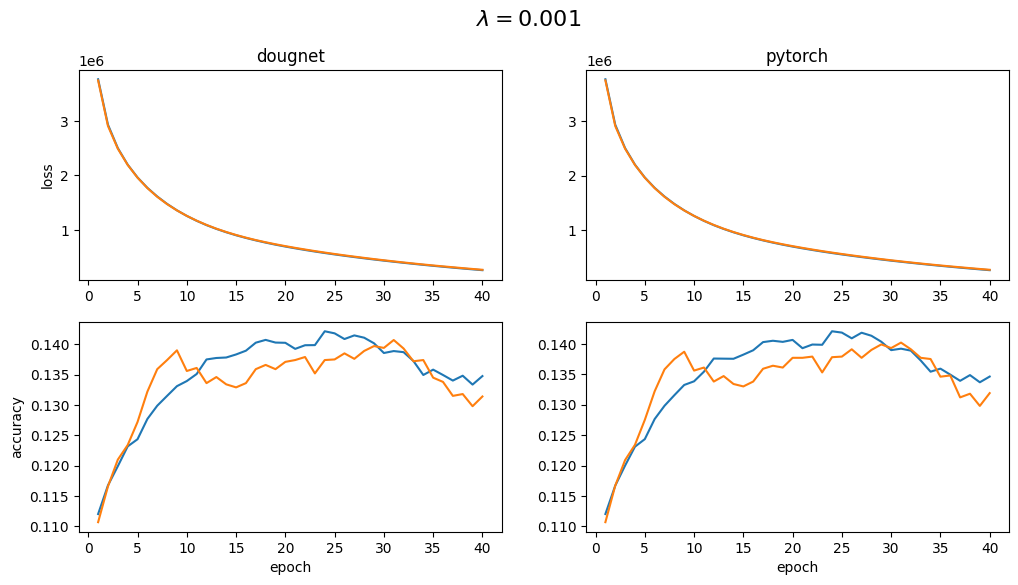

In [9]:
# plot results

progress_dict = {.001: progress}
progress_torch_dict = {.001: progress_torch}
plot_results(progress_dict, progress_torch_dict, .001)

As we can see, performance tops out only at about 14%.  I am also forced to use a very small learning rate due to divergence issues from poor weight initialization.

# Weight Initialization

The biggest improvment to model performance will most likely be due to initializing model weights properly.

### Xavier initialization

In [10]:
# train

eta = .01

progress_dict = {}
progress_torch_dict = {}
for (epochs, lmbda) in [(40, .001), (100, .01)]:
    graph = dn.ComputationGraph()
    model_dn = DougnetModel(weight_init="xavier")
    model_torch = PytorchModel()
    
    progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.SGD)
    progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.SGD)
    progress_dict[lmbda] = progress
    progress_torch_dict[lmbda] = progress_torch

number of model parameters: 355810


epoch: 100%|███████████████| 40/40 [02:38<00:00,  3.97s/epoch]                                               


number of model parameters: 355810


epoch: 100%|███████████████| 100/100 [05:57<00:00,  3.57s/epoch]                                             


best dougnet validation accuracy = 0.518
best pytorch validation accuracy = 0.521


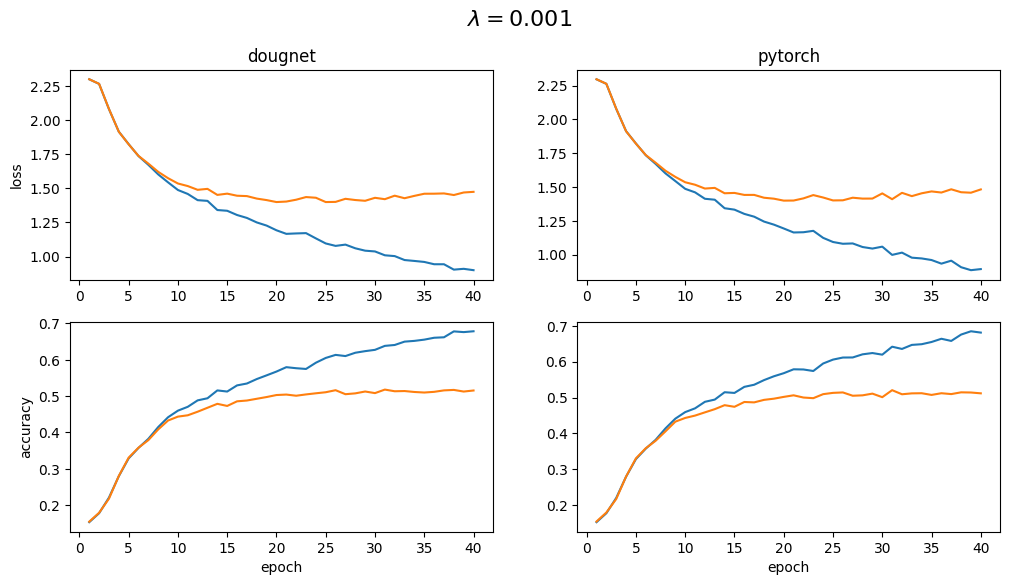

In [11]:
plot_results(progress_dict, progress_torch_dict, .001)

best dougnet validation accuracy = 0.487
best pytorch validation accuracy = 0.488


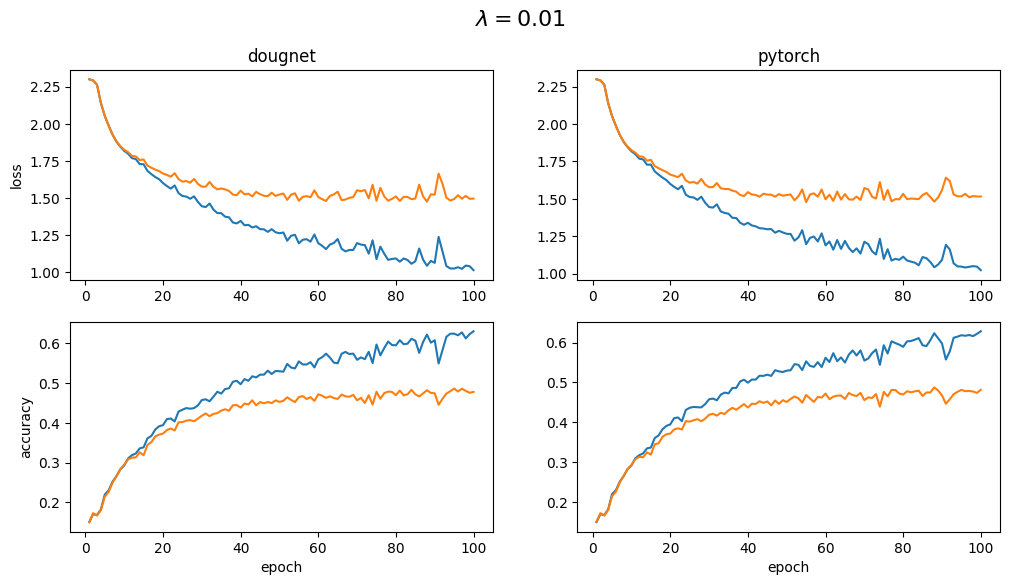

In [12]:
plot_results(progress_dict, progress_torch_dict, .01)

Initializing the weights properly has improved model performance dramatically.  For $\lambda=0.01$ convergence is slow and I am forced to train till 100 epochs.  Additionally, validation set performance for $\lambda=0.01$ is inferior to $\lambda=0.001$.

# Optimization Algorithms

I now incorporate more specialized optimization algorithms into training.

### SGD with momentum

In [13]:
eta = .01

progress_dict = {}
progress_torch_dict = {}
for (epochs, lmbda) in [(40, .001), (60, .01)]:
    graph = dn.ComputationGraph()
    model_dn = DougnetModel(weight_init="xavier")
    model_torch = PytorchModel()
    
    progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.SGD, momentum=.9)
    progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.SGD, momentum=.9)
    progress_dict[lmbda] = progress
    progress_torch_dict[lmbda] = progress_torch

number of model parameters: 355810


epoch: 100%|███████████████| 40/40 [02:52<00:00,  4.31s/epoch]                                               


number of model parameters: 355810


epoch: 100%|███████████████| 60/60 [03:31<00:00,  3.53s/epoch]                                               


best dougnet validation accuracy = 0.535
best pytorch validation accuracy = 0.533


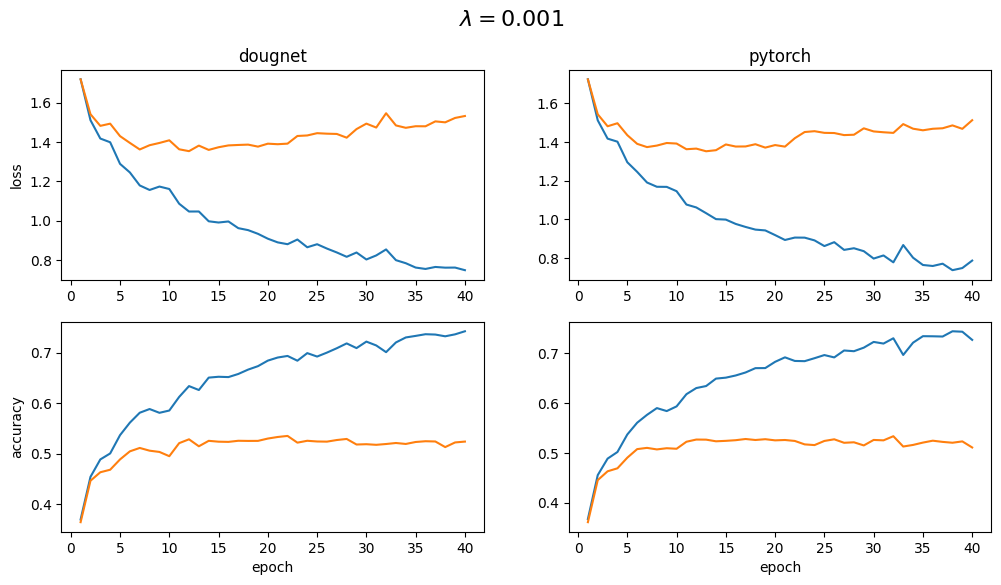

In [14]:
plot_results(progress_dict, progress_torch_dict, .001)

best dougnet validation accuracy = 0.44
best pytorch validation accuracy = 0.438


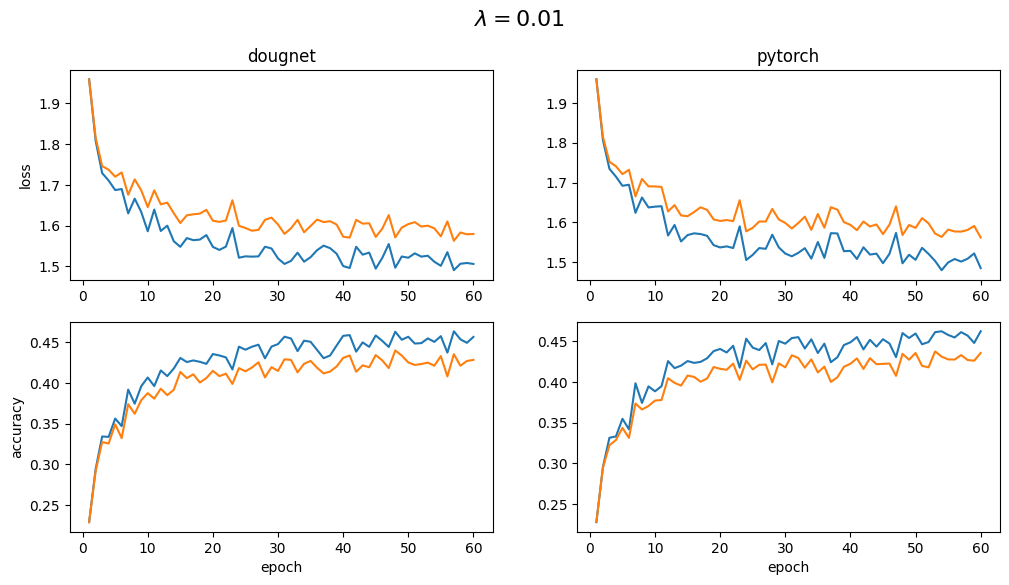

In [15]:
plot_results(progress_dict, progress_torch_dict, .01)

Momentum increases the validation performance by about $1\%$ for $\lambda = 0.001$.  However, we see substantial overfitting.  Increasing the regularization to $\lambda = 0.01$ reduces the overfitting, but results in a somewhat unstable model and overall worse performance than vanilla SGD.

### Adam

In [16]:
eta, epochs = .0001, 40

progress_dict = {}
progress_torch_dict = {}
for lmbda in [.001, .01]:
    graph = dn.ComputationGraph()
    model_dn = DougnetModel(weight_init="xavier")
    model_torch = PytorchModel()
    
    progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.Adam)
    progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.Adam)
    progress_dict[lmbda] = progress
    progress_torch_dict[lmbda] = progress_torch

number of model parameters: 355810


epoch: 100%|███████████████| 40/40 [07:24<00:00, 11.12s/epoch]                                               


number of model parameters: 355810


epoch: 100%|███████████████| 40/40 [10:29<00:00, 15.74s/epoch]                                               


best dougnet validation accuracy = 0.525
best pytorch validation accuracy = 0.529


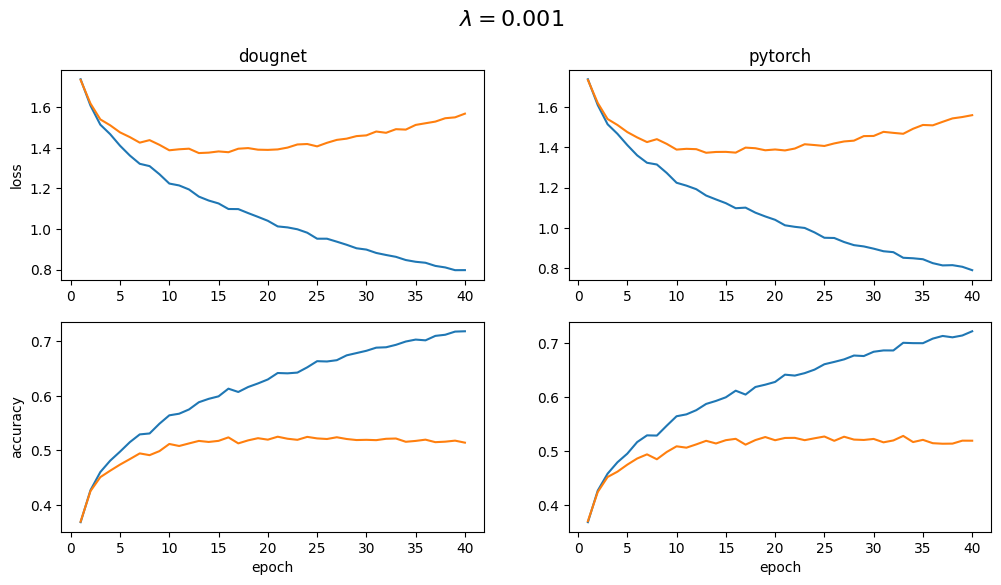

In [17]:
plot_results(progress_dict, progress_torch_dict, .001)

best dougnet validation accuracy = 0.492
best pytorch validation accuracy = 0.499


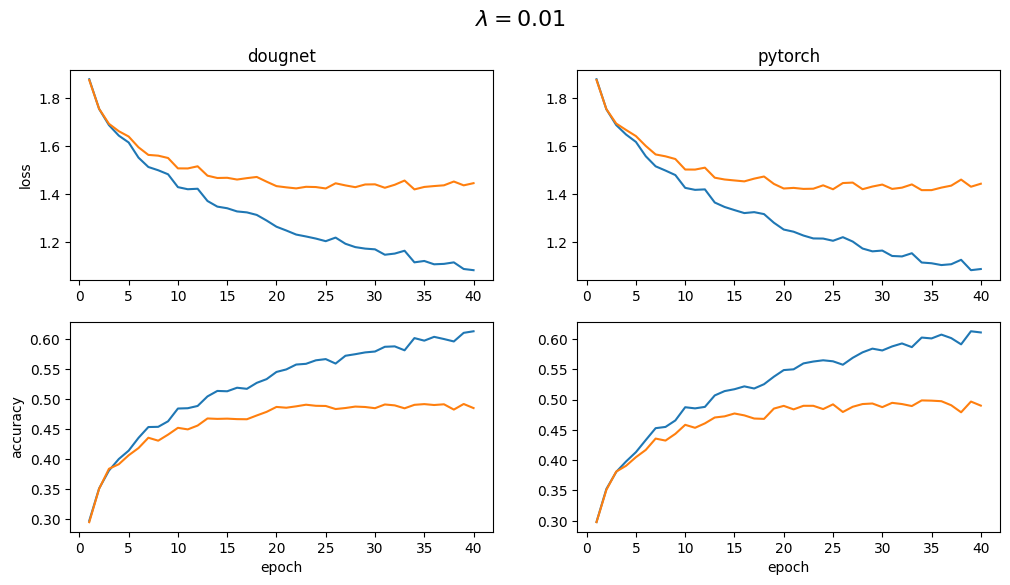

In [18]:
plot_results(progress_dict, progress_torch_dict, .01)

Adam allows much faster convergence than SGD and SGD+momentum, so I need to train for fewer epochs.  We still see overfitting for $\lambda = 0.001$ and the validation performance for $\lambda = 0.01$ is still inferior to the $\lambda = 0.001$ case.

# Batch norm

I now incorporate batch norm into each layer of my MLP.

In [19]:
# define dougnet any pytorch models
# architecture/number of neurons/layer:
# 0) 3x32x32
# 1) relu(BN(100))
# 2) relu(BN(100))
# 3) relu(BN(100))
# 4) relu(BN(100))
# 5) relu(BN(100))
# 6) relu(BN(50))
# 7) relu(BN(50))
# 8) 10

class DougnetModel(dn.Module):
    def __init__(self, weight_init="normal"):
    
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()

        # define hidden layers
        activation = self.X
        self.pre_activations = []
        for i in range(7):
            self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[i], 
                                                  NUM_FEATURES_IN[i], weight_init=weight_init))
            activation = dn.Relu(dn.BN1d(self.pre_activations[-1].module_output, NUM_FEATURES_OUT[i]))

        # define output layer    
        self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[7], 
                                              NUM_FEATURES_IN[7], weight_init=weight_init))
        super().__init__()
        
    def forward_(self):
        return self.pre_activations[-1].module_output
    
    
class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pre_activations = []
        for i in range(8):
            self.pre_activations.append(nn.Linear(NUM_FEATURES_IN[i], NUM_FEATURES_OUT[i]))
            
        self.bns = []
        for i in range(7):
            self.bns.append(nn.BatchNorm1d(NUM_FEATURES_OUT[i]))
            
    def forward(self, x):
        
        A = F.relu(self.bns[0](self.pre_activations[0](x)))
        for i in range(1, 7):
            A = F.relu(self.bns[i](self.pre_activations[i](A)))
        return self.pre_activations[7](A)

In [20]:
eta, epochs = .0001, 30

progress_dict = {}
progress_torch_dict = {}
for lmbda in [.001, .01]:
    graph = dn.ComputationGraph()
    model_dn = DougnetModel(weight_init="xavier")
    model_torch = PytorchModel()
    
    progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.Adam)
    progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.Adam)
    progress_dict[lmbda] = progress
    progress_torch_dict[lmbda] = progress_torch

number of model parameters: 357010


epoch: 100%|███████████████| 30/30 [04:03<00:00,  8.12s/epoch]                                               


number of model parameters: 357010


epoch: 100%|███████████████| 30/30 [03:45<00:00,  7.50s/epoch]                                               


best dougnet validation accuracy = 0.502
best pytorch validation accuracy = 0.509


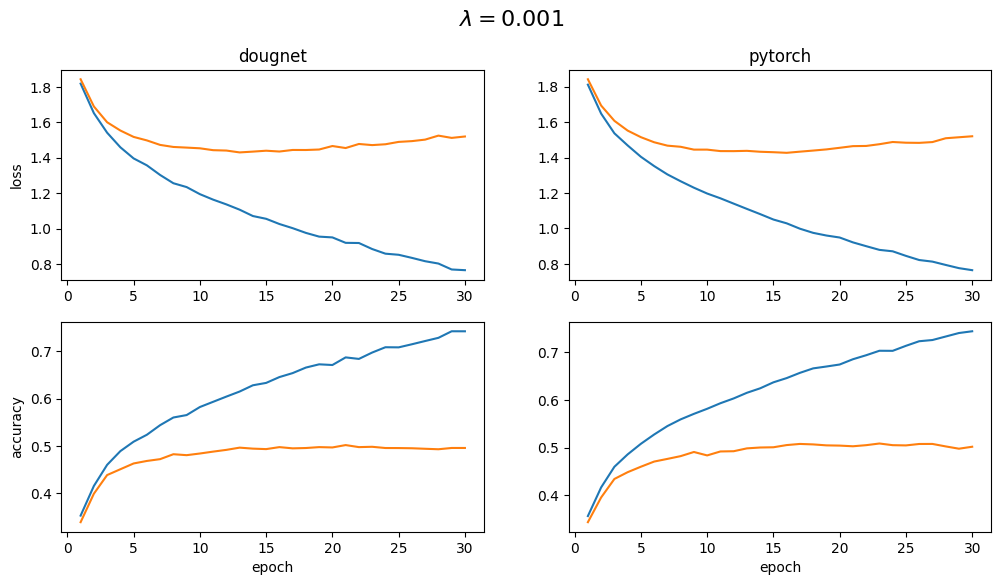

In [21]:
plot_results(progress_dict, progress_torch_dict, .001)

best dougnet validation accuracy = 0.519
best pytorch validation accuracy = 0.523


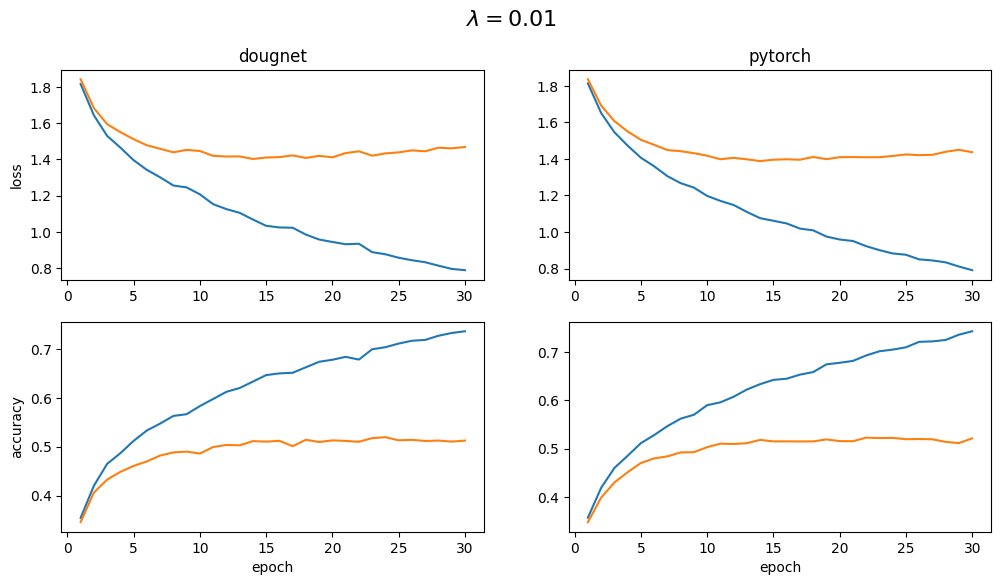

In [22]:
plot_results(progress_dict, progress_torch_dict, .01)

The validation performance for the $\lambda=0.001$ case is slightly worse than not using batch norm.  However, batch norm increases the performance of the $\lambda=0.01$ model by about $3%$, finally making it competitive with the $\lambda=0.001$ model.

# Dropout

As a final improvement, I add dropout to each hidden layer.  In the pytorch model, I do not use pytorch's nn.Dropout(.) class and instead implement dropout with a custom dropout(.) function defined below.  I do this for fair comparison to my Dougnet model, since this allows me to use the same exact numpy rng to generate the same sequence of masks that the dougnet model uses during training.

In [23]:
# define dougnet any pytorch models
# architecture/number of neurons/layer:
# 0) 3x32x32
# 1) dropout(relu(BN(100)))
# 2) dropout(relu(BN(100)))
# 3) dropout(relu(BN(100)))
# 4) dropout(relu(BN(100)))
# 5) dropout(relu(BN(100)))
# 6) dropout(relu(BN(50)))
# 7) dropout(relu(BN(50)))
# 8) 10

class DougnetModel(dn.Module):
    def __init__(self, p, dropout_seed, weight_init="normal"):
        self.p = p
        self.random_state = np.random.RandomState(dropout_seed)
    
        # input
        self.X = dn.InputNode()
        self.Y = dn.InputNode()

        # define hidden layers
        activation = self.X
        self.pre_activations = []
        for i in range(7):
            self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[i], 
                                                  NUM_FEATURES_IN[i], weight_init=weight_init))
            activation = dn.Dropout(dn.Relu(dn.BN1d(self.pre_activations[-1].module_output, 
                                                    NUM_FEATURES_OUT[i])), self.p, self.random_state)
        # define output layer    
        self.pre_activations.append(dn.Linear(activation, NUM_FEATURES_OUT[7], 
                                              NUM_FEATURES_IN[7], weight_init=weight_init))
        super().__init__()
        
    def forward_(self):
        return self.pre_activations[-1].module_output
    
    
def dropout(x, p, random_state, training):
    if training:
        mask = torch.tensor((random_state.binomial(1, 1-p, size=(x.shape[1], x.shape[0])) / (1 - p)
                            ).astype(np.float32))
        mask = mask.T
        return mask * x
    return x

    
class PytorchModel(nn.Module):
    def __init__(self, p, dropout_seed):
        super().__init__()
        self.p = p
        
        self.pre_activations = []
        for i in range(8):
            self.pre_activations.append(nn.Linear(NUM_FEATURES_IN[i], NUM_FEATURES_OUT[i]))
            
        self.bns = []
        for i in range(7):
            self.bns.append(nn.BatchNorm1d(NUM_FEATURES_OUT[i]))
            
        self.random_state = np.random.RandomState(dropout_seed)
            
    def forward(self, x):
        A = dropout(F.relu(self.bns[0](self.pre_activations[0](x))), self.p, self.random_state, 
                    self.training)
        for i in range(1, 7):
            A = dropout(F.relu(self.bns[i](self.pre_activations[i](A))), self.p, self.random_state, 
                        self.training)
        return self.pre_activations[7](A)

In [24]:
eta, epochs = .0001, 40

progress_dict = {}
progress_torch_dict = {}
for lmbda in [.01, .001]:
    graph = dn.ComputationGraph()
    model_dn = DougnetModel(.1, SEED_DROPOUT, weight_init="xavier")
    model_torch = PytorchModel(.1, SEED_DROPOUT)
    
    progress, weights = train_dougnet(graph, model_dn, lmbda, eta, epochs, dn.optim.Adam)
    progress_torch = train_torch(model_torch, weights, lmbda, eta, epochs, torch.optim.Adam)
    progress_dict[lmbda] = progress
    progress_torch_dict[lmbda] = progress_torch

number of model parameters: 357010


epoch: 100%|███████████████| 40/40 [06:17<00:00,  9.45s/epoch]                                               


number of model parameters: 357010


epoch: 100%|███████████████| 40/40 [06:23<00:00,  9.59s/epoch]                                               


best dougnet validation accuracy = 0.54
best pytorch validation accuracy = 0.54


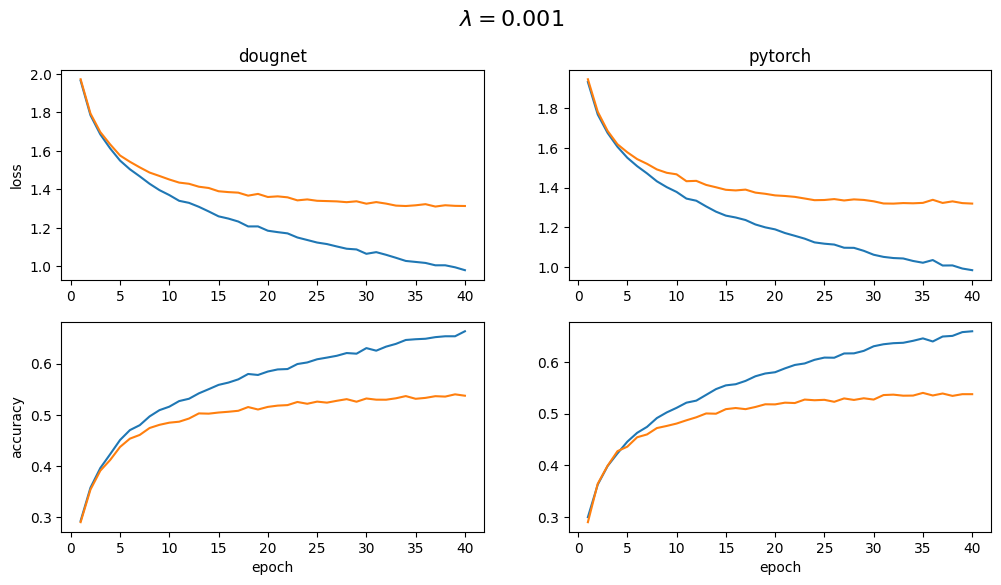

In [25]:
plot_results(progress_dict, progress_torch_dict, .001)

best dougnet validation accuracy = 0.547
best pytorch validation accuracy = 0.549


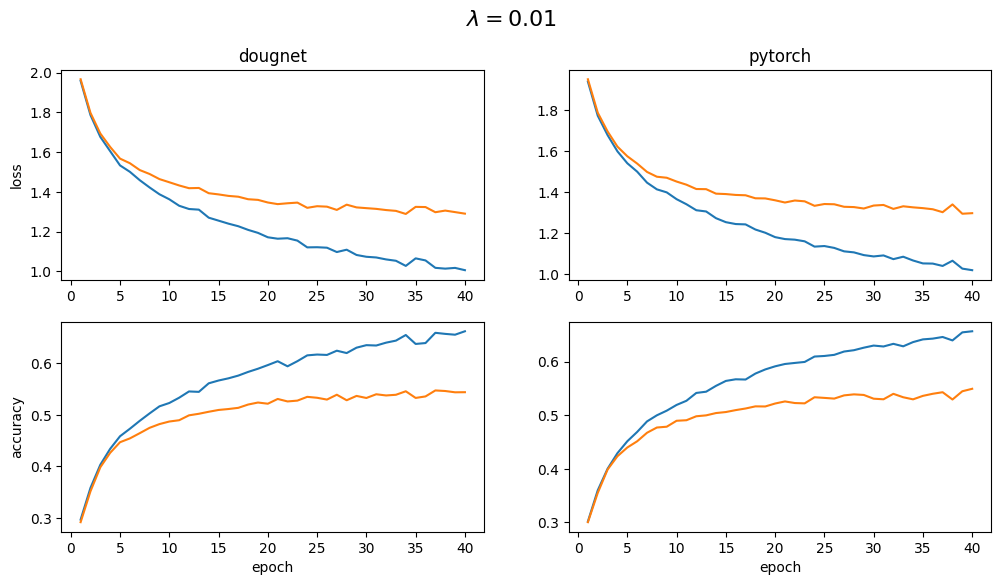

In [26]:
plot_results(progress_dict, progress_torch_dict, .01)

Dropout clearly regularizes both the $\lambda= 0.001$ and $\lambda= 0.01$ models (i.e., the training and validation curves are closer together).  It increases validation accuracy by about $3\%$ for both models.

# Summary
I enumerate the performance benefit of each additional method for the $\lambda = 0.01$ model:
- vanilla MLP: $\sim 12\%$ accuracy
- weight initialization (Xavier): $\sim 49\%$ accuracy ($\Delta \approx 37 \%$)
- optimization algo (Adam): $\sim 50\%$ accuracy ($\Delta \approx 1 \%$), with substantial gains in number of epochs till convergence
- Batch norm: $\sim 52\%$ accuracy ($\Delta \approx 2 \%$)
- Dropout: $\sim 55\%$ accuracy ($\Delta \approx 3 \%$)